In [146]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

In [147]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# 1. Dataset

In [148]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/OnlineRetail.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [149]:
df.shape

(541909, 8)

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [151]:
df['Country'].value_counts(normalize=True)

,proportion
Country,
United Kingdom,0.914320
Germany,0.017521
France,0.015790
EIRE,0.015124
Spain,0.004674
Netherlands,0.004375
Belgium,0.003818
Switzerland,0.003694
Portugal,0.002803


In [152]:
df = df[df['Country']=='United Kingdom']

since more than 90% of data is from UK, we will only focus on UK for our analysis

# 2. Feature Engineering and EDA

In [153]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [154]:
pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

,InvoiceDate
0,2010-12
1,2010-12
2,2010-12
3,2010-12
4,2010-12
...,...
541889,2011-12
541890,2011-12
541891,2011-12
541892,2011-12


In [155]:
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

### monthly revenue

In [156]:
df['Revenue'] = df['UnitPrice'] * df['Quantity']

In [157]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


In [158]:
monthly_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().sort_index().reset_index()
monthly_revenue

,InvoiceYearMonth,Revenue
0,2010-12,676742.620
1,2011-01,434308.300
2,2011-02,408247.910
3,2011-03,559707.390
4,2011-04,442254.041
5,2011-05,596459.860
6,2011-06,554478.350
7,2011-07,565479.841
8,2011-08,539130.500
9,2011-09,862018.152


In [159]:
plot_data = [
    go.Scatter(
        x=monthly_revenue['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=monthly_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=300, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

* stable growth from Jan to Aug
* high revenue growth in Sep and Nov
* peak sales is in Nov'11

### monthly growth rate

In [160]:
monthly_revenue['MonthlyGrowth'] = monthly_revenue['Revenue'].pct_change()
monthly_revenue

,InvoiceYearMonth,Revenue,MonthlyGrowth
0,2010-12,676742.620,NaN
1,2011-01,434308.300,-0.358237
2,2011-02,408247.910,-0.060004
3,2011-03,559707.390,0.370999
4,2011-04,442254.041,-0.209848
5,2011-05,596459.860,0.348682
6,2011-06,554478.350,-0.070384
7,2011-07,565479.841,0.019841
8,2011-08,539130.500,-0.046596
9,2011-09,862018.152,0.598904


In [161]:
plot_data = [
    go.Scatter(
        x=monthly_revenue['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=monthly_revenue['MonthlyGrowth'].round(2),
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=300, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

* 21% decline in Apr
* 60% growth in Sep and 46% growth in Nov

### monthly active users

In [162]:
monthly_active_users = df.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()
monthly_active_users

,InvoiceYearMonth,CustomerID
0,2010-12,871
1,2011-01,684
2,2011-02,714
3,2011-03,923
4,2011-04,817
5,2011-05,985
6,2011-06,943
7,2011-07,899
8,2011-08,867
9,2011-09,1177


In [163]:
plot_data = [
    go.Bar(
        x=monthly_active_users['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=monthly_active_users['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=400, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

### monthly volume

In [164]:
monthly_volume = df.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
monthly_volume

,InvoiceYearMonth,Quantity
0,2010-12,298101
1,2011-01,237381
2,2011-02,225641
3,2011-03,279843
4,2011-04,257666
5,2011-05,306452
6,2011-06,258522
7,2011-07,324129
8,2011-08,319804
9,2011-09,458490


In [165]:
plot_data = [
    go.Bar(
        x=monthly_volume['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=monthly_volume['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Volume'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=400, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

### monthly avg revenue

In [166]:
monthly_avg_revenue = df.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()
monthly_avg_revenue

,InvoiceYearMonth,Revenue
0,2010-12,16.865860
1,2011-01,13.614680
2,2011-02,16.093027
3,2011-03,16.716166
4,2011-04,15.773380
5,2011-05,17.713823
6,2011-06,16.714748
7,2011-07,15.723497
8,2011-08,17.315899
9,2011-09,18.931723


In [167]:
plot_data = [
    go.Bar(
        x=monthly_avg_revenue['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=monthly_avg_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Avg Revenue'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=400, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

### new customers

In [168]:
customer_first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
customer_first_purchase.rename(columns={'InvoiceDate': 'FirstPurchaseDate'}, inplace=True)
customer_first_purchase['FirstPurchaseYearMonth'] = customer_first_purchase['FirstPurchaseDate'].dt.to_period('M')
customer_first_purchase.drop('FirstPurchaseDate', axis=1, inplace=True)
customer_first_purchase.head()

,CustomerID,FirstPurchaseYearMonth
0,12346.0,2011-01
1,12747.0,2010-12
2,12748.0,2010-12
3,12749.0,2011-05
4,12820.0,2011-01


In [169]:
df = pd.merge(df, customer_first_purchase, on='CustomerID')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,FirstPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12


In [170]:
df['UserType'] = 'New'
df.loc[df['InvoiceYearMonth'] > df['FirstPurchaseYearMonth'], 'UserType'] = 'Existing'
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,FirstPurchaseYearMonth,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30,2010-12,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00,2010-12,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12,New


In [171]:
usertype_monthly_revenue = df.groupby(['InvoiceYearMonth', 'UserType'])['Revenue'].sum().reset_index()
usertype_monthly_revenue.drop(0, inplace=True)

In [172]:
plot_data = [
    go.Scatter(
        x=usertype_monthly_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=usertype_monthly_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=usertype_monthly_revenue.query("UserType == 'New'")['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=usertype_monthly_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        title='New vs Existing Customers'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=300, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

* existing customers show a positive trend
* new customers are not increasing

### new customer ratio

In [173]:
new_customer_ratio = df.query("UserType == 'New'").groupby('InvoiceYearMonth')['CustomerID'].nunique() / df.query("UserType == 'Existing'").groupby('InvoiceYearMonth')['CustomerID'].nunique()
new_customer_ratio = new_customer_ratio.reset_index()
new_customer_ratio.dropna(inplace=True)
new_customer_ratio

,InvoiceYearMonth,CustomerID
1,2011-01,1.124224
2,2011-02,0.904000
3,2011-03,0.792233
4,2011-04,0.510166
5,2011-05,0.343793
6,2011-06,0.281250
7,2011-07,0.236589
8,2011-08,0.192572
9,2011-09,0.304878
10,2011-10,0.328852


In [174]:
plot_data = [
    go.Bar(
        x=new_customer_ratio['InvoiceYearMonth'].dt.strftime("%b'%y"),
        y=new_customer_ratio['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(width=800, height=400, margin=dict(l=20, r=20, t=40, b=20))
fig.show()

new customer ratio has declined as expected

# 3. RFM Segmentation

In [175]:
def ascending_quantile(x, quantile):
    if x <= quantile[0.25]:
        return 1
    elif x <= quantile[0.50]:
        return 2
    elif x <= quantile[0.75]:
        return 3
    else:
        return 4

def descending_quantile(x, quantile):
  if x <= quantile[0.25]:
    return 4
  elif x <= quantile[0.5]:
    return 3
  elif x <= quantile[0.75]:
    return 2
  else:
    return 1

## 3.1 recency

In [176]:
user = pd.DataFrame(df['CustomerID'].unique(), columns=['CustomerID'])
user.head()

,CustomerID
0,17850.0
1,13047.0
2,13748.0
3,15100.0
4,15291.0


In [177]:
recent_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recent_purchase.columns = ['CustomerID', 'RecentPurchaseDate']
recent_purchase.head()

,CustomerID,RecentPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [178]:
recent_purchase['Recency'] = recent_purchase['RecentPurchaseDate'].apply(lambda x: (recent_purchase['RecentPurchaseDate'].max() - x).days)
recent_purchase.head()

,CustomerID,RecentPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [179]:
plot_data = [
    go.Histogram(
        x=recent_purchase['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(
    width=800,
    height=500
)
fig.show()

* active customers -> [0, 50]
* inactive customers -> >100

In [180]:
recency_quantile = recent_purchase['Recency'].quantile([0.25, 0.5, 0.75])
recency_quantile

,Recency
0.25,16.0
0.50,49.0
0.75,142.0


In [181]:
recent_purchase['RecencyCluster'] = recent_purchase['Recency'].apply(lambda x: ascending_quantile(x, recency_quantile))
recent_purchase.head()

,CustomerID,RecentPurchaseDate,Recency,RecencyCluster
0,12346.0,2011-01-18 10:17:00,325,4
1,12747.0,2011-12-07 14:34:00,1,1
2,12748.0,2011-12-09 12:20:00,0,1
3,12749.0,2011-12-06 09:56:00,3,1
4,12820.0,2011-12-06 15:12:00,2,1


In [182]:
user = pd.merge(user, recent_purchase[['CustomerID', 'Recency', 'RecencyCluster']], on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,4
1,13047.0,31,2
2,13748.0,95,3
3,15100.0,329,4
4,15291.0,25,2


## 3.2 frequency

In [183]:
customer_frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
customer_frequency.columns = ['CustomerID', 'Frequency']
customer_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [184]:
plot_data = [
    go.Histogram(
        x=customer_frequency.query("Frequency < 1000")['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(
    width=800,
    height=500
)
fig.show()

In [185]:
frequency_quantile = customer_frequency['Frequency'].quantile([0.25, 0.5, 0.75])
frequency_quantile

,Frequency
0.25,17.0
0.50,41.0
0.75,101.0


In [186]:
customer_frequency['FrequencyCluster'] = customer_frequency['Frequency'].apply(lambda x: descending_quantile(x, frequency_quantile))
customer_frequency.head()

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,4
1,12747.0,103,1
2,12748.0,4642,1
3,12749.0,231,1
4,12820.0,59,2


In [187]:
user = pd.merge(user, customer_frequency, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,4,312,1
1,13047.0,31,2,196,1
2,13748.0,95,3,28,3
3,15100.0,329,4,6,4
4,15291.0,25,2,109,1


## 3.3 revenue

In [188]:
customer_revenue = df.groupby('CustomerID')['Revenue'].sum().reset_index()
customer_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [189]:
plot_data = [
    go.Histogram(
        x=customer_revenue.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(
    width=800,
    height=500
)
fig.show()

In [190]:
revenue_quantile = customer_revenue['Revenue'].quantile([0.25, 0.5, 0.75])
revenue_quantile

,Revenue
0.25,282.2550
0.50,627.0600
0.75,1521.7825


In [191]:
customer_revenue['RevenueCluster'] = customer_revenue['Revenue'].apply(lambda x: descending_quantile(x, revenue_quantile))
customer_revenue.head()

,CustomerID,Revenue,RevenueCluster
0,12346.0,0.00,4
1,12747.0,4196.01,1
2,12748.0,29072.10,1
3,12749.0,3868.20,1
4,12820.0,942.34,2


In [192]:
user = pd.merge(user, customer_revenue, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,4,312,1,5288.63,1
1,13047.0,31,2,196,1,3079.10,1
2,13748.0,95,3,28,3,948.25,2
3,15100.0,329,4,6,4,635.10,2
4,15291.0,25,2,109,1,4596.51,1


## segmentation

In [193]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,4,312,1,5288.63,1
1,13047.0,31,2,196,1,3079.10,1
2,13748.0,95,3,28,3,948.25,2
3,15100.0,329,4,6,4,635.10,2
4,15291.0,25,2,109,1,4596.51,1


In [194]:
user['rfm'] = user['RecencyCluster'].map(str) + user['FrequencyCluster'].map(str) + user['RevenueCluster'].map(str)
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,rfm
0,17850.0,301,4,312,1,5288.63,1,411
1,13047.0,31,2,196,1,3079.10,1,211
2,13748.0,95,3,28,3,948.25,2,332
3,15100.0,329,4,6,4,635.10,2,442
4,15291.0,25,2,109,1,4596.51,1,211


In [195]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1,1020.0,6.730392,4.930813,0.0,2.0,7.0,10.00,16.0
2,975.0,30.185641,9.368752,17.0,22.0,29.0,38.00,49.0
3,968.0,82.628099,25.790904,50.0,62.0,75.0,101.25,142.0
4,987.0,245.486322,67.149394,143.0,186.5,240.0,297.50,373.0


In [196]:
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1,986.0,264.808316,391.048899,102.0,130.0,176.0,283.75,7983.0
2,985.0,66.127919,17.254429,42.0,51.0,63.0,80.00,101.0
3,949.0,27.935722,6.639693,18.0,22.0,28.0,33.00,41.0
4,1030.0,8.864078,4.820084,1.0,5.0,9.0,13.00,17.0


In [197]:
user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
1,988.0,5293.003878,12409.639249,1521.79,2019.555,2764.795,4595.985,256438.49
2,987.0,984.899170,259.171711,627.13,755.640,948.050,1187.990,1521.76
3,987.0,427.019485,101.819391,282.45,336.695,408.800,508.520,626.99
4,988.0,146.580820,185.684575,-4287.63,110.800,161.655,215.735,282.19


In [198]:
def rfm_segmentation(x):
  if x['RecencyCluster'] == 1 and x['FrequencyCluster'] <= 2 and x['RevenueCluster'] <= 2:
    return 'Best'
  elif x['RecencyCluster'] <= 2 and x['FrequencyCluster'] <= 2:
    return 'Loyal'
  elif x['RecencyCluster'] == 3 and x['RevenueCluster'] <= 2:
    return 'Churn Risk'
  elif x['RevenueCluster'] == 1:
    return 'Big Spenders'
  elif x['RecencyCluster'] == 4:
    return 'Lost'
  else:
    return 'Normal'

In [199]:
user['segment'] = user.apply(rfm_segmentation, axis=1)
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,rfm,segment
0,17850.0,301,4,312,1,5288.63,1,411,Big Spenders
1,13047.0,31,2,196,1,3079.10,1,211,Loyal
2,13748.0,95,3,28,3,948.25,2,332,Churn Risk
3,15100.0,329,4,6,4,635.10,2,442,Lost
4,15291.0,25,2,109,1,4596.51,1,211,Loyal


In [200]:
plot_data = [
    go.Pie(
        labels=user['segment'].value_counts().index,
        values=user['segment'].value_counts().values,
        hole=.3
    )
]

plot_layout = go.Layout(title='Customer Segmentation')

fig = go.Figure(plot_data, plot_layout)
fig.update_layout(
    width=800,
    height=500
)
fig.show()

In [201]:
user['segment'].value_counts().reset_index()

,segment,count
0,Normal,1101
1,Lost,951
2,Best,711
3,Loyal,662
4,Churn Risk,451
5,Big Spenders,74


strategies for the business:

* Best Customers - who are very active, buy frequently, and make high value purchases
  * keep them engaged and reward loyalty
  * personalized rewards: exclusive discounts and early access to sale
  * goal: maintain their engagement and increase lifetime value

* Loyal Customers - who are active and frequent buyers, but not of high value
  * subscription plans: points based membership that can be redeemed during next purchase
  * goal: increase revenue per customer through higher engagement

*  Bigtime Spenders - who spend a lot, but don't buy frequently
  * limited time offers: create urgency with time sensitive deals
  * premium products: offer premium and exclusive products to cater to their high spending
  * goal: increase their purchase frequency, while maintaining high spending

* Churn Risk - who were once valuable, but have started disengaging
  * reminder mails: mails containing details about cost savings of past purchases
  * best discount deals: provide them with the highest discount deals available on the market to bring them back to the store
  * goal: prevent them from moving to the "Lost" category

* Lost - who haven't purchased in a long time and might have found an alternative
  * survey: to understand why they left and receive feedback
  * filtered marketing: only market to the high value ones
  * goal: reactivate high value lost customers, while filtering out the low value ones

* Normal - who make regular purchases but haven't reached "Loyalty" category yet
  * loyalty incentives: encourage repeat purchases with small rewards
  * goal: convert them into loyal customers

## evaluation

<Axes: xlabel='Revenue', ylabel='Count'>

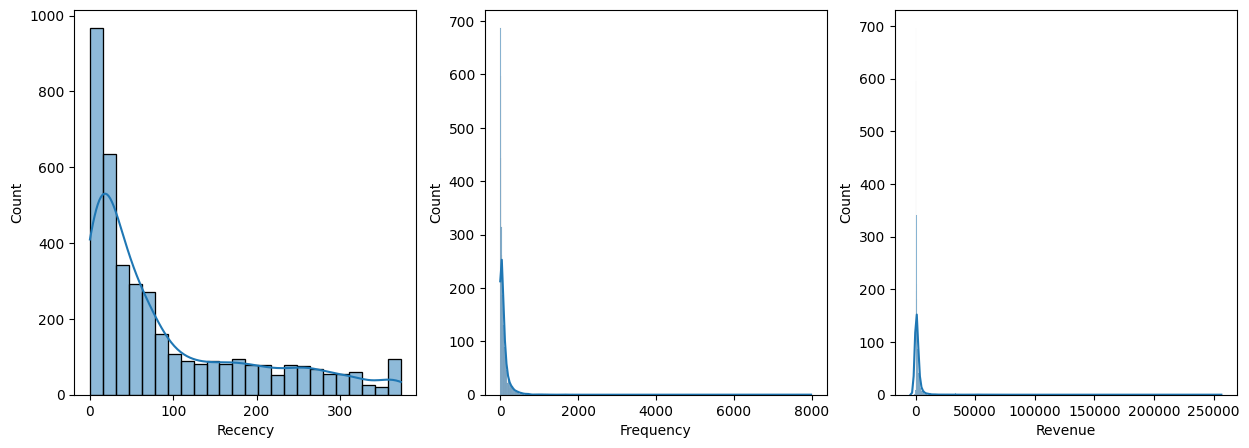

In [202]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

sns.histplot(user['Recency'], ax=ax[0], kde=True)
sns.histplot(user['Frequency'], ax=ax[1], kde=True)
sns.histplot(user['Revenue'], ax=ax[2], kde=True)

In [203]:
user_rfm = user[['Recency', 'Frequency', 'Revenue']]
user_rfm = user_rfm.clip(lower=0)
user_rfm = np.log1p(user_rfm)
user_rfm = pd.DataFrame(user_rfm, columns=user_rfm.columns)
user_rfm.head()

,Recency,Frequency,Revenue
0,5.710427,5.746203,8.573504
1,3.465736,5.283204,8.032717
2,4.564348,3.367296,6.855672
3,5.799093,1.945910,6.455356
4,3.258097,4.700480,8.433270


<Axes: xlabel='Revenue', ylabel='Count'>

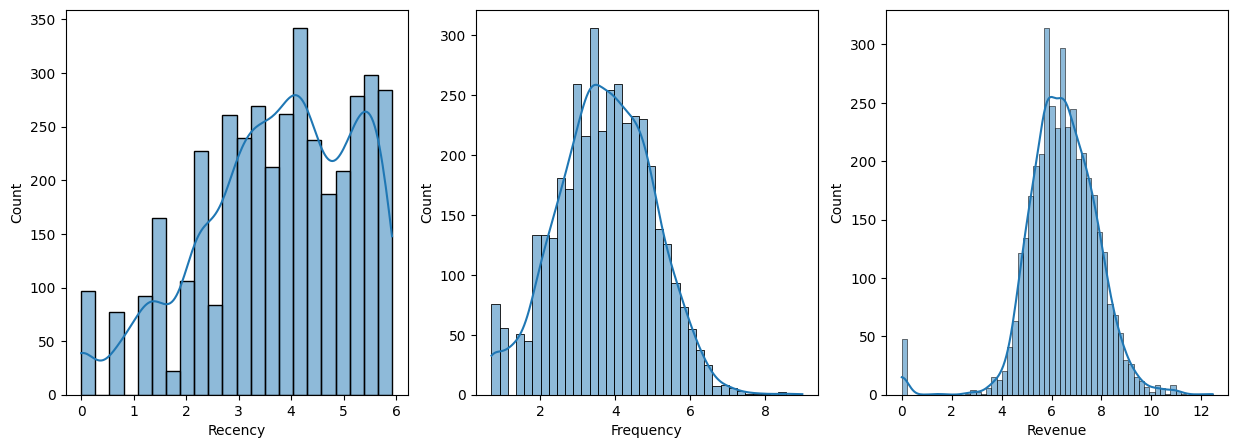

In [204]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

sns.histplot(user_rfm['Recency'], ax=ax[0], kde=True)
sns.histplot(user_rfm['Frequency'], ax=ax[1], kde=True)
sns.histplot(user_rfm['Revenue'], ax=ax[2], kde=True)

In [205]:
daviess_bouldin_score = davies_bouldin_score(user_rfm, user['segment'])
daviess_bouldin_score

2.0545432518808595

# 4. K-Means Model

In [206]:
rfm = user[['Recency', 'Frequency', 'Revenue']]
rfm.head()

,Recency,Frequency,Revenue
0,301,312,5288.63
1,31,196,3079.10
2,95,28,948.25
3,329,6,635.10
4,25,109,4596.51


In [207]:
rfm.describe()

,Recency,Frequency,Revenue
count,3950.000000,3950.000000,3950.000000
mean,90.778481,91.614684,1713.385669
std,100.230349,220.557389,6548.608224
min,0.000000,1.000000,-4287.630000
25%,16.000000,17.000000,282.255000
50%,49.000000,41.000000,627.060000
75%,142.000000,101.000000,1521.782500
max,373.000000,7983.000000,256438.490000


<Axes: >

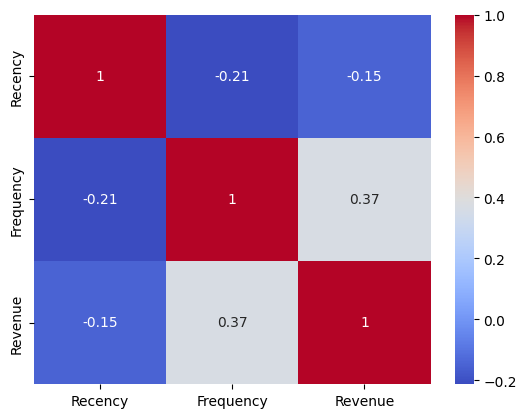

In [208]:
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm')

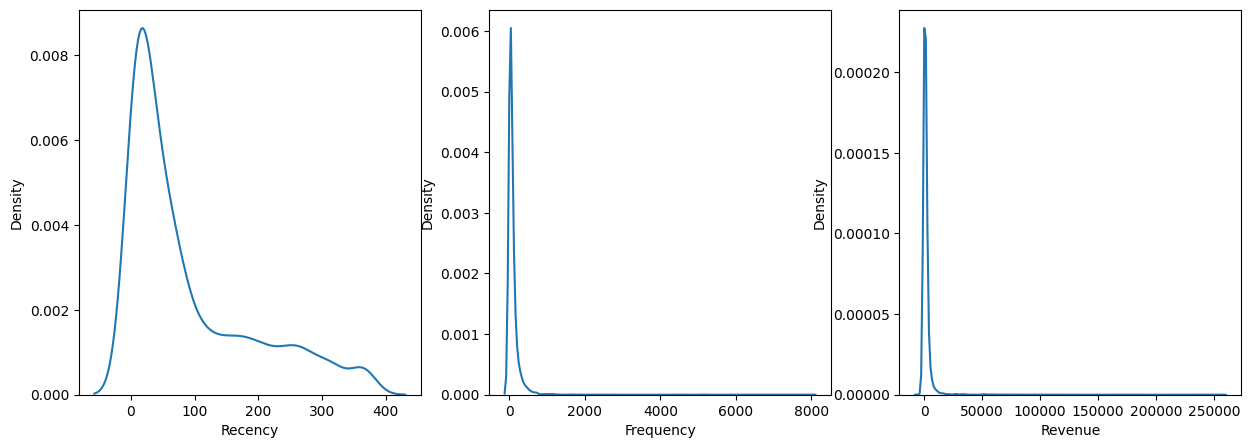

In [209]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

for i, col in enumerate(rfm.columns):
  sns.kdeplot(data=rfm, x=col, ax=ax[i])

* all distributions are heavily right skewed
* kmeans gives best results when data is not skewed and standardized

In [210]:
rfm = rfm.clip(lower=0)
rfm_trf = np.log1p(rfm)
rfm_trf = pd.DataFrame(rfm_trf, columns=rfm_trf.columns)
rfm_trf.head()

,Recency,Frequency,Revenue
0,5.710427,5.746203,8.573504
1,3.465736,5.283204,8.032717
2,4.564348,3.367296,6.855672
3,5.799093,1.945910,6.455356
4,3.258097,4.700480,8.433270


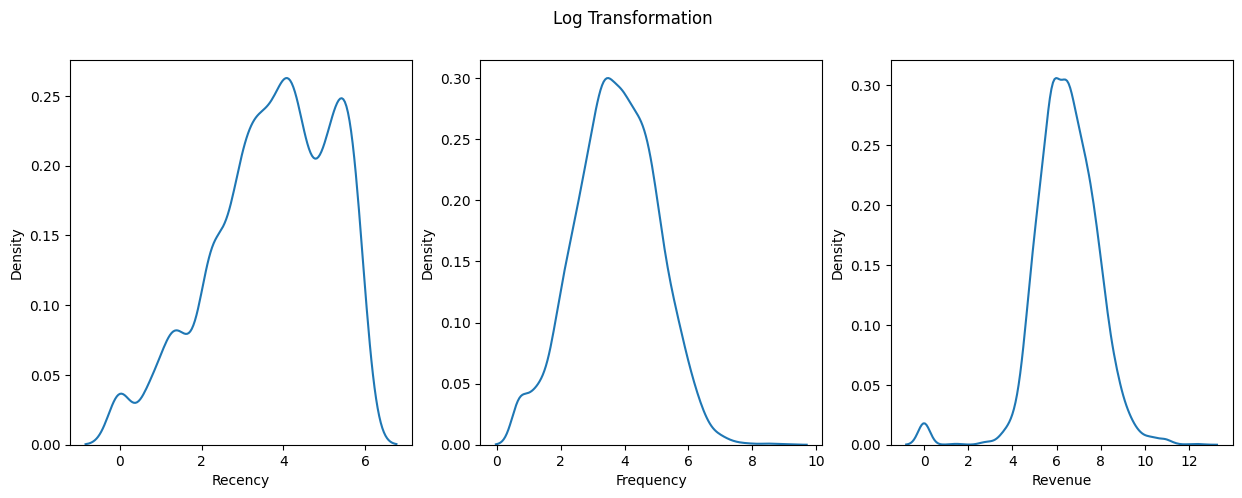

In [211]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

for i, col in enumerate(rfm.columns):
  sns.kdeplot(data=rfm_trf, x=col, ax=ax[i])

fig.suptitle('Log Transformation')
plt.show()

## elbow method

In [212]:
ssd = []
K = range(1, 15)
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(rfm_trf)
  ssd.append(kmeans.inertia_)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=ssd, mode='lines+markers'))
fig.update_layout(
    width=800,
    height=500,
    title='Elbow Method',
    xaxis_title='K',
    yaxis_title='SSD')
fig.show()

In [213]:
def kmeans_scatter_plot(df, df_trf, clusters):
  kmeans = KMeans(n_clusters=clusters, random_state=42)
  kmeans.fit(df_trf)
  cluster_labels = kmeans.labels_
  df_new = df.assign(Cluster=cluster_labels)

  fig = px.scatter_3d(
    rfm, x="Recency", y="Frequency", z="Revenue",
    color=df_new["Cluster"].astype(str),
    title=f"K-Means Clusters: {clusters}",
    color_discrete_sequence=px.colors.qualitative.Set1,
    template="plotly_white",
    opacity=0.8
  )

  fig.update_layout(
    width=800,
    height=500
  )

  fig.show()

In [111]:
kmeans_scatter_plot(rfm, rfm_trf, 3)

In [112]:
kmeans_scatter_plot(rfm, rfm_trf, 4)

In [113]:
kmeans_scatter_plot(rfm, rfm_trf, 5)

In [115]:
def kmeans_tsne_plot(df, df_trf, clusters):
  kmeans = KMeans(n_clusters=clusters, random_state=42)
  kmeans.fit(df_trf)
  cluster_labels = kmeans.labels_
  df_new = df.assign(Cluster=cluster_labels)

  tsne = TSNE(n_components=2, random_state=42)
  tsne_features = tsne.fit_transform(df_trf)

  # Step 4: Convert t-SNE Result to DataFrame
  df_new["TSNE-1"] = tsne_features[:, 0]
  df_new["TSNE-2"] = tsne_features[:, 1]

  # Step 5: Create 2D Scatter Plot with t-SNE
  fig = px.scatter(
      df_new, x="TSNE-1", y="TSNE-2",
      color=df_new["Cluster"].astype(str),
      title=f"K-Means Clusters (t-SNE 2D) - {clusters} Clusters",
      color_discrete_sequence=px.colors.qualitative.Set1,
      template="plotly_white",
      opacity=0.8
  )

  fig.update_layout(
      width=800,
      height=500
  )

  fig.show()

In [117]:
kmeans_tsne_plot(rfm, rfm_trf, 3)

In [118]:
kmeans_tsne_plot(rfm, rfm_trf, 4)

In [119]:
kmeans_tsne_plot(rfm, rfm_trf, 5)

## kmeans evaluation

In [128]:
def kmeans_evaluation(df, k):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df)
  return f"Davies-Bouldin Score for k({k}): {davies_bouldin_score(df, kmeans.labels_):.2f}"

In [129]:
print(kmeans_evaluation(rfm_trf, 3))
print(kmeans_evaluation(rfm_trf, 4))
print(kmeans_evaluation(rfm_trf, 5))
print(kmeans_evaluation(rfm_trf, 6))
print(kmeans_evaluation(rfm_trf, 7))

Davies-Bouldin Score for k(3): 1.10
Davies-Bouldin Score for k(4): 0.96
Davies-Bouldin Score for k(5): 0.92
Davies-Bouldin Score for k(6): 0.96
Davies-Bouldin Score for k(7): 0.96


* k=5 has the lowest davies bouldin score = 0.92

In [130]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_trf)
cluster_labels = kmeans.labels_
rfm_final = rfm.assign(Cluster=cluster_labels)
rfm_final.head()

,Recency,Frequency,Revenue,Cluster
0,301,312,5288.63,4
1,31,196,3079.10,4
2,95,28,948.25,4
3,329,6,635.10,1
4,25,109,4596.51,4


In [131]:
rfm_final['Cluster'].value_counts()

,count
Cluster,
1,1284
4,1176
0,720
3,713
2,57


In [132]:
rfm_final.groupby('Cluster')[['Recency', 'Frequency', 'Revenue']].quantile(0.5).reset_index()

,Cluster,Recency,Frequency,Revenue
0,0,17.0,28.0,394.54
1,1,184.0,14.0,255.51
2,2,217.0,2.0,0.00
3,3,6.0,191.0,2919.81
4,4,56.0,78.0,1114.18


K-Means Customer Segmentation:

* Potential Loyalist (0): active + moderate freq + mid revenue
  * offer loyalty programs and exclusive discounts
  * cross sell based on past purchases

* Churn Risk (1): inactive + low freq + low revenue
  * re-engagement email campaign
  * offer huge discounts to bring them back

* Lost Customers (2): very inactive + very low freq + no revenue
  * survey to identify reasons for churn
  * remove from marketing lists to save on budget

* Best Customers (3): very active + very high freq + very high revenue
  * provide priority customer service
  * invite to vip memberships
  * early access to discounts

* Frequent Big Spenders (4): active + high freq + high revenue
  * encourage higher value purchases
  * provide attractive discounts to make them more active